In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow.keras.backend as K
import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm

In [2]:
vocab = spm.SentencePieceProcessor()
vocab.load("./data/ko_32000.model")

True

In [3]:
def create_pretrain_mask(tokens, vacab_list):
    tokens_orgin = copy.deepcopy(tokens)
    word_index = []
    temp = []
    for i, token in enumerate(tokens):
        if token != "[CLS]" and token != "[SEP]":
            if i > 1 and token.startswith(u"\u2581"):
                word_index.append(temp)
                temp = [i]
            else:
                temp.append(i)
                
    max_count = int((len(word_index)-3)*0.15)
    mask_list = []
    while len(mask_list) < max_count:
        index = random.choice(word_index)
        if index not in mask_list: 
            mask_list.append(index)
        
            per = random.randint(0, 100)
        
            if per < 80:
                for i in index: tokens[i] = "[MASK]"
            elif per > 90:
                for i in index: tokens[i] = random.choice(vacab_list)
                    
    mask_index = sorted([j for i in mask_list for j in i])
    mask_label = [tokens_orgin[i] for i in mask_index]
    
    return tokens, mask_index, mask_label

In [4]:
def trim_tokens(left_tokens, right_tokens, max_len):
    total_len = len(left_tokens) + len(right_tokens)
    while total_len > max_len:
        if len(left_tokens) > len(right_tokens): del left_tokens[0]
        else: right_tokens.pop()
        total_len -= 1

In [5]:
def create_pretrain_instances(vocab, doc, n_seq, vocab_list):
    max_len = n_seq-3
    
    instances = []
    temp_sentences = []
    temp_len = 0
    for i, sentence in enumerate(doc):
        temp_sentences.append(sentence)
        temp_len += len(sentence)
        
        if len(temp_sentences) > 1 and (i == len(doc)-1 or temp_len >= max_len):
            pivot = random.randrange(1, len(temp_sentences))
            
            left_tokens = []
            right_tokens = []
            for j in range(pivot): left_tokens += temp_sentences[j]
            for j in range(pivot, len(temp_sentences)): right_tokens += temp_sentences[j]
            
            is_next = 0
            if random.randint(0, 100) < 50:
                tokens_temp = left_tokens
                left_tokens = right_tokens
                right_tokens = tokens_temp
            else:
                is_next = 1
                
            trim_tokens(left_tokens, right_tokens, max_len)
            assert 0 < len(left_tokens), "zero left token"
            assert 0 < len(right_tokens), "zero right token"
            
            tokens = ["[CLS]"] + left_tokens + ["[SEP]"] + right_tokens + ["[SEP]"]
            segment = [0] * (len(left_tokens) + 2) + [1] * (len(right_tokens) + 1)
            
            tokens, mask_index, mask_label = create_pretrain_mask(tokens, vocab_list)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_index,
                "mask_label": mask_label
            }
            instances.append(instance)
            
            temp_sentences = []
            temp_len = 0
            
    return instances

In [6]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    def save_pretrain_instances(out_f, doc, vocab_list):
        instances = create_pretrain_instances(vocab, doc, n_seq, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    vocab_list = []
    for id in range(7, 8000):
        if not vocab.is_unknown(id):      
            vocab_list.append(vocab.id_to_piece(id))

    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":  
                    if 0 < len(doc):
                        save_pretrain_instances(out_f, doc, vocab_list)
                        doc = []
                else: 
                    pieces = vocab.encode_as_pieces(line)
                    if 0 < len(pieces):
                        doc.append(pieces)
            if 0 < len(doc): 
                save_pretrain_instances(out_f, doc)
                doc = []

In [7]:
pretrain_json_path = "./data/bert_pre_train.json"
corpus_file = "./data/kowiki.txt"
make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)

  0%|          | 0/3957761 [00:00<?, ?it/s]

In [8]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            if count is not None and count <= total:
                break
    
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            
            label_nsp = data["is_next"]
            
            mask_idx = np.array(data["mask_idx"], dtype=np.int)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
            label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [9]:
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128, count=128000)

  0%|          | 0/128000 [00:00<?, ?it/s]

/tmp/ipykernel_32/682462427.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_idx = np.array(data["mask_idx"], dtype=np.int)
/tmp/ipykernel_32/682462427.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in 

data load early stop 128000 128000


In [10]:
def get_pad_mask(tokens, i_pad=0):
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask

def get_ahead_mask(tokens, i_pad=0):
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask

In [11]:
@tf.function(experimental_relax_shapes=True)
def gelu(x):
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))

In [12]:
def kernel_initializer(stddev=0.02):
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)

def bias_initializer():
    return tf.zeros_initializer

In [13]:
class Config(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [14]:
class SharedEmbedding(tf.keras.layers.Layer):
    def __init__(self, config, name="weight_shared_embedding"):
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        if mode == "embedding":
            return self._embedding(inputs)
        elif mode == "linear":
            return self._linear(inputs)
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

In [15]:
class PositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, config, name="position_embedding"):
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

In [16]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    def __init__(self, name="scale_dot_product_attention"):
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [17]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, config, name="multi_head_attention"):
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        
        self.attention = ScaleDotProductAttention(name="self_attention")
        
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)#(bs, q_len, n_head, d_head)
                                                        #(bs, n_head, len, len)
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
                                                                # (bs, num_head, d_model, Q_len)
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out

In [18]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    def __init__(self, config, name="feed_forward"):
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [19]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, config, name="encoder_layer"):
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

In [20]:
class BERT(tf.keras.layers.Layer):
    def __init__(self, config, name="bert"):
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        enc_tokens, segments = inputs

        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

In [21]:
class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(config.d_model, activation=tf.nn.tanh, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.dense2 = tf.keras.layers.Dense(n_output, use_bias=False, activation=tf.nn.softmax, name="nsp", kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
 
    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs

In [22]:
def build_model_pre_train(config):
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))
    return model

In [23]:
config = Config({"d_model": 256, "n_head": 4, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 3, "n_seq": 256, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 256,
 'n_head': 4,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 3,
 'n_seq': 256,
 'n_vocab': 32007,
 'i_pad': 0}

In [24]:
n_seq = 10

enc_tokens = np.random.randint(0, len(vocab), (10, n_seq))
segments = np.random.randint(0, 2, (10, n_seq))
labels_nsp = np.random.randint(0, 2, (10,))
labels_mlm = np.random.randint(0, len(vocab), (10, n_seq))

In [25]:
def lm_loss(y_true, y_pred):
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss * 20

In [26]:
def lm_acc(y_true, y_pred):
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy

In [27]:
class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr

In [28]:
pre_train_model = build_model_pre_train(config)
pre_train_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_tokens (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
segments (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bert (BERT)                     ((None, 256), (None, 10629632    enc_tokens[0][0]                 
                                                                 segments[0][0]                   
__________________________________________________________________________________________________
pooled_nsp (PooledOutput)       (None, 2)            66304       bert[0][0]                   

In [29]:
epochs = 10
batch_size = 64

train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

pre_train_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss), optimizer=optimizer, metrics={"nsp": "acc", "mlm": lm_acc})

In [30]:
save_weights = tf.keras.callbacks.ModelCheckpoint("./data/bert_pre_train.hdf5", monitor="mlm_lm_acc", verbose=1, save_best_only=True, mode="max", save_freq="epoch", save_weights_only=True)

history = pre_train_model.fit(pre_train_inputs, pre_train_labels, epochs=epochs, batch_size=batch_size, callbacks=[save_weights])

Epoch 1/10
2000/2000 [==============================] - 567s 279ms/step - loss: 20.5859 - nsp_loss: 0.6476 - mlm_loss: 19.9382 - nsp_acc: 0.5992 - mlm_lm_acc: 0.0936

Epoch 00001: mlm_lm_acc improved from -inf to 0.09363, saving model to ./data/bert_pre_train.hdf5
Epoch 2/10
2000/2000 [==============================] - 566s 283ms/step - loss: 18.4141 - nsp_loss: 0.6133 - mlm_loss: 17.8008 - nsp_acc: 0.6459 - mlm_lm_acc: 0.1389

Epoch 00002: mlm_lm_acc improved from 0.09363 to 0.13888, saving model to ./data/bert_pre_train.hdf5
Epoch 3/10
2000/2000 [==============================] - 567s 283ms/step - loss: 16.8231 - nsp_loss: 0.5866 - mlm_loss: 16.2366 - nsp_acc: 0.6931 - mlm_lm_acc: 0.1563

Epoch 00003: mlm_lm_acc improved from 0.13888 to 0.15634, saving model to ./data/bert_pre_train.hdf5
Epoch 4/10
2000/2000 [==============================] - 567s 283ms/step - loss: 15.3052 - nsp_loss: 0.5570 - mlm_loss: 14.7482 - nsp_acc: 0.7333 - mlm_lm_acc: 0.1829

Epoch 00004: mlm_lm_acc improved

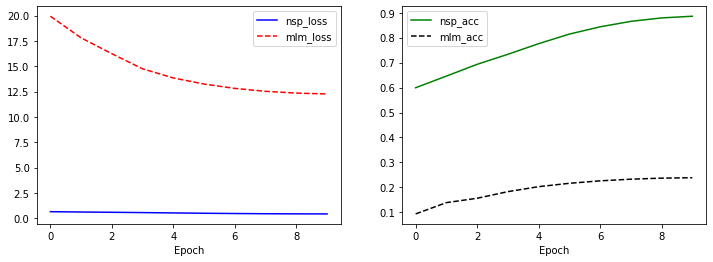

In [31]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['nsp_loss'], 'b-', label='nsp_loss')
plt.plot(history.history['mlm_loss'], 'r--', label='mlm_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['nsp_acc'], 'g-', label='nsp_acc')
plt.plot(history.history['mlm_lm_acc'], 'k--', label='mlm_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## 결론
### BERT를 구현하고 한국어 위키피디아 데이터로 pretrain시켜봤습니다. 역시 개발자 출신이 아니여서그런지 json쓰는 거는 여전히 까다롭네ㅎㅎ 그나저나 노드 만드신분 짬 좀 되시던데 코드는 개판ㅠㅠㅠ 역시 짬과 코드는 비례하지 않는다는 명제 다시 확인
### 그나마 쫌 큰 데이터를 처음 다뤄보는데 역시 많은 난관들이 보입니다. 메모리맵핑쓰는거나 컨피규 커널 세팅등 여러부분에서 디테일하게 잡을텐데 나같은 코더는 너무 귀찮은~~~~~개발자는 못해먹겟닼ㅋㅋㅋㅋ
### 어쨋든 간만에 코딩다운 코딩좀 해보고 나름 재미났던 프로젝트 사실상 사전학습만시키고 써보진않아서 성능평가가 안됫던 프로젝트 이제부터 써보면 되지 머~~~